In [67]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler

import matplotlib.pyplot as plt
import pandas as pd
import umap.umap_ as umap
import plotly.express as px
import numpy as np
import os
import plotly.graph_objects as go

In [68]:
def z_score(X):
    # X: ndarray, shape (n_features, n_samples)
    # ss = StandardScaler(with_mean=True, with_std=True)
    # ss = RobustScaler()
    ss = MaxAbsScaler()
    Xz = ss.fit_transform(X)
    return Xz

In [118]:
d = pd.read_csv(r"doubleTrackData.csv")
d = d[d["exposure"] == 1]
d.reset_index(drop=True, inplace=True)
data = d.dropna()
allGoodCol = data.columns
allGoodCol = list(allGoodCol)
allGoodCol = allGoodCol[5::]

# nbRUN1 = len(data[data["exposure"] == 1]["lap"].unique())
# nbRUN2 = len(data[data["exposure"] == 2]["lap"].unique())

# print("Number of neurons : ", len(allGoodCol))
# print("Nb of lap of the 1st exposure is", nbRUN1)
# print("Nb of lap of the 2nd exposure is", nbRUN2)

meanLength = int(np.mean([len(data[data["lap"] == i]) for i in range(1, data["lap"].max() + 1)]))

# # We can reduce the number of laps in RUN2 to 16
# # print("Cropping RUN2 to 16 laps")
# # data = data[data['lap'] < len(data[data["exposure"] == 1]["lap"].unique()) + 16]
# # print("Number of laps :", len(data["lap"].unique()))

# # We reduce the number of lab in RUN2 to the same as in RUN1 to avoid any bias
# print("Cropping RUN2 to RUN1 length")
# data = data[data['lap'] < 2*nbRUN1 + 1]

parsedData = data[allGoodCol].values

In [119]:
# pca = PCA(n_components=20, svd_solver='full')
# pca = FastICA(n_components=3, random_state=0, whiten='unit-variance')
pca = KernelPCA(n_components=20, kernel="cosine")

pca_embedding = pca.fit_transform(z_score(parsedData))
pca_embedding = pca_embedding[:,0:3]

df = pd.DataFrame(pca_embedding, columns=['x1', 'x2', 'x3'])
df["x"] = data.x
df["lap"] = data.lap
df["track"] = data.track
df["exposure"] = data.exposure

fig = px.scatter_3d(df, x='x1', y='x2', z='x3', color='x', opacity=0.9, title="PCA")
fig.update_traces(marker_size=2)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [120]:
plt.plot(pca.explained_variance_ratio_, marker='o')
plt.xlabel("Number of components")
plt.ylabel("Explained variance")
plt.title("PCA explained variance")
plt.show()

AttributeError: 'KernelPCA' object has no attribute 'explained_variance_ratio_'

In [ ]:
# For this one, we need to make every trial the same length with interpolation

print("Mean length: ", meanLength)

interpolatedData = np.zeros((meanLength, 3, data["lap"].max()))
interpolatedPos = np.zeros((meanLength, (data["lap"].max())))

for i in range(1, data["lap"].max() + 1):

    posData = data[data["lap"] == i]

    lapData = pca_embedding[data["lap"] == i, :]

    durationTrial = len(lapData)
    timeVector = [(1/durationTrial) * i for i in range(0, durationTrial)]
    goalVector = [(1/meanLength) * i for i in range(0, meanLength)]
    positionVector = posData["x"]

    if durationTrial != meanLength:
        newDataMat = np.zeros((meanLength, 3))
        interpPos = np.interp(goalVector, timeVector, positionVector)
        for d in range(0, 3):
            neuralData = lapData[:, d]
            interpVector = np.interp(goalVector, timeVector, neuralData)
            newDataMat[:, d] = interpVector
    else:
        newDataMat = lapData

    interpolatedData[:, :, i - 1] = newDataMat
    interpolatedPos[:, i - 1] = interpPos

Mean length:  67


ValueError: array of sample points is empty

In [ ]:
# We're taking the lap-to-lap mean euclinidian distance between the two runs

meanDist = np.zeros((data["lap"].max(), 1))
for i in range(1, data["lap"].max()):
    meanDist[i] = np.median(np.linalg.norm(interpolatedData[:, :, i] - interpolatedData[:, :, i - 1], axis=1))

In [132]:
# Now that we have our main trajectories, we can project SWR data in the space

# Load the replay data - MAKE SURE IT'S THE SAME ANIMAL !

dRep = pd.read_csv(r"replayDataShuffled.csv")
dataRep = dRep.dropna()
allGoodColRep = dataRep.columns
allGoodColRep = list(allGoodColRep)
allGoodColRep = allGoodColRep[3::]

parsedDataRep = dataRep[allGoodCol].values
embeddingRep = pca.transform(parsedDataRep)

embeddingRep = embeddingRep[:,0:3]

from scipy.spatial import distance

# For each point in the replay, we want to find the closest point in the original data - exposure == 2

distMat = distance.cdist(embeddingRep, pca_embedding, 'euclidean')

# We find the index of the minimum on each line
minIndex = np.argmin(distMat, axis = 1)

# We can now decode the variables

# Now we retrieve the position of the closest point
x = df["x"].values
dRep["dx"] = x[minIndex]

# We retrieve the exposure of the closest point
exposure = df["exposure"].values
dRep["dexposure"] = exposure[minIndex]

# We retrieve the lap of the closest point
lap = df["lap"].values
dRep["dlap"] = lap[minIndex]

# We retrieve the track of the closest point
track = df["track"].values
dRep["dtrack"] = track[minIndex]

Text(0.5, 0, 'Lap')

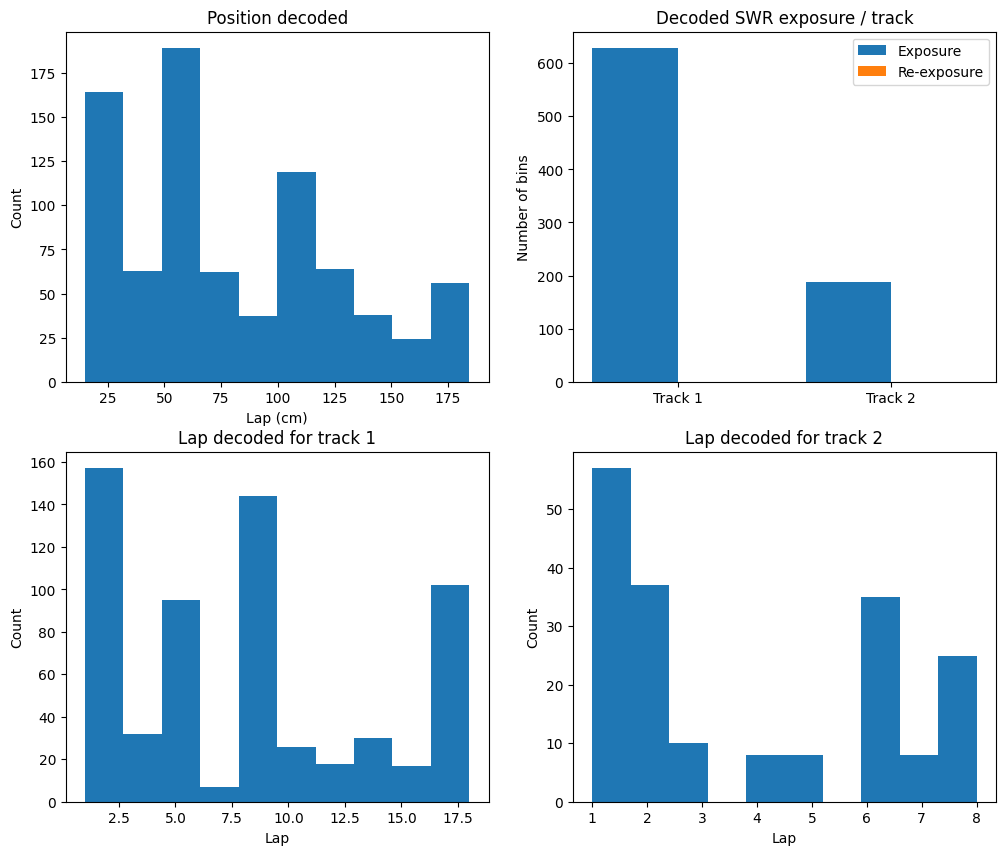

In [133]:
# Are the Lap decoded paving the tracks ?

plt.figure(figsize=(12, 10))  # Increase the width to 12 inches and height to 6 inches

plt.subplot(2, 2, 1)
plt.hist(dRep["dx"])
plt.title("Position decoded")
plt.ylabel("Count")
plt.xlabel("Lap (cm)")

# Do we see that track 2 is less replayed than track 1 ? Do we see a replay of the re-exposure for each ?

plt.subplot(2, 2, 2)

nbRepExpT1 = len(dRep["dexposure"][(dRep["dtrack"] == 1) & (dRep["dexposure"] == 1)])
nbRepReExpT1 = len(dRep["dexposure"][(dRep["dtrack"] == 1) & (dRep["dexposure"] == 2)])
nbRepExpT2 = len(dRep["dexposure"][(dRep["dtrack"] == 2) & (dRep["dexposure"] == 1)])
nbRepReExpT2 = len(dRep["dexposure"][(dRep["dtrack"] == 2) & (dRep["dexposure"] == 2)])

# Define the labels for the bars
labels = ['Track 1', 'Track 2']

# Define the heights of the bars
left_bars = [nbRepExpT1, nbRepExpT2]
right_bars = [nbRepReExpT1, nbRepReExpT2]

# Define the Laps for the bars on the x-axis
x = np.arange(len(labels))
rects1 = plt.bar(x - 0.2, left_bars, 0.4, label='Exposure')
rects2 = plt.bar(x + 0.2, right_bars, 0.4, label='Re-exposure')

# Add labels, title and custom x-axis tick labels, etc.
plt.ylabel('Number of bins')
plt.title('Decoded SWR exposure / track')
plt.xticks(x, labels)
plt.legend()

plt.subplot(2, 2, 3)
plt.hist(dRep[dRep["dtrack"] == 1]["dlap"])
plt.title("Lap decoded for track 1")
plt.ylabel("Count")
plt.xlabel("Lap")

plt.subplot(2, 2, 4)
plt.hist(dRep[dRep["dtrack"] == 2]["dlap"])
plt.title("Lap decoded for track 2")
plt.ylabel("Count")
plt.xlabel("Lap")



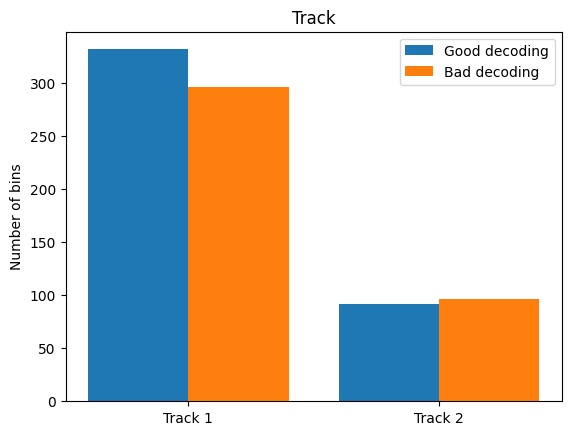

In [134]:
### Look at the correlation betwwen bayesian decoding of the track and manifold

nbGoodDecT1 = len(dRep[(dRep["dtrack"] == 1) & (dRep["track"] == 1)])
nbGoodDecT2 = len(dRep[(dRep["dtrack"] == 2) & (dRep["track"] == 2)])
nbBadDecT1 = len(dRep[(dRep["dtrack"] == 1) & (dRep["track"] == 2)])
nbBadDecT2 = len(dRep[(dRep["dtrack"] == 2) & (dRep["track"] == 1)])

# Define the labels for the bars
labels = ['Track 1', 'Track 2']

# Define the heights of the bars
left_bars = [nbGoodDecT1, nbGoodDecT2]
right_bars = [nbBadDecT1, nbBadDecT2]

# Define the Laps for the bars on the x-axis
x = np.arange(len(labels))
rects1 = plt.bar(x - 0.2, left_bars, 0.4, label = 'Good decoding')
rects2 = plt.bar(x + 0.2, right_bars, 0.4, label = 'Bad decoding')

plt.ylabel('Number of bins')
plt.title('Track')
plt.xticks(x, labels)
plt.legend()

In [135]:
fig = go.Figure(data=[go.Scatter3d(x= df["x1"], y= df["x2"], z = df["x3"], mode='markers')])

fig.add_trace(go.Scatter3d(x=embeddingRep[:, 0], y=embeddingRep[:, 1], z=embeddingRep[:, 2], mode='markers'))

fig.update_traces(marker_size=2)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

#### The projection of replay in PCA components seems bad

## Dual PCA method testing

In [136]:
pca = PCA(n_components=20, svd_solver='full')

pca_embeddingT1 = pca.fit_transform(z_score(parsedData[data.track == 1]))
pca_embeddingT1 = pca_embeddingT1[:, 0:3]

pca_embeddingT2 = pca.fit_transform(z_score(parsedData[data.track == 2]))
pca_embeddingT2 = pca_embeddingT2[:, 0:3]

df = pd.DataFrame(pca_embeddingT1, columns=['x1', 'x2', 'x3'])
dataT1 = data[data.track == 1]
dataT1.reset_index(drop=True, inplace=True)

df["x"] = dataT1.x
df["lap"] = dataT1.lap
df["track"] = dataT1.track
df["exposure"] = dataT1.exposure

df2 = pd.DataFrame(pca_embeddingT2, columns=['x1', 'x2', 'x3'])
dataT2 = data[data.track == 2]
dataT2.reset_index(drop=True, inplace=True)

df2["x"] = dataT2.x
df2["lap"] = dataT2.lap
df2["track"] = dataT2.track
df2["exposure"] = dataT2.exposure

# Merge df and df2
df = pd.concat([df, df2])

fig = px.scatter_3d(df, x='x1', y='x2', z='x3', color='x', opacity=0.9, title="PCA")
fig.update_traces(marker_size=2)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [137]:
# Everything is merged, not clear what to do next